In [ ]:
import os
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import spacy
from spacy import displacy
from top2vec import Top2Vec
from wordcloud import WordCloud, STOPWORDS

from config import Config
from preprocessing.sentiment_analysis import get_sentiment

In [2]:
#nlp = spacy.load('Jodie')
nlp = spacy.load('en_core_web_lg')

In [3]:
file_name = '0001104659-06-084288.txt'
data_file = os.path.join(Config.risk_dir(), file_name)

In [4]:
with open(data_file, 'r') as df:
    data = df.read()

In [5]:
STOPWORDS.add('company')

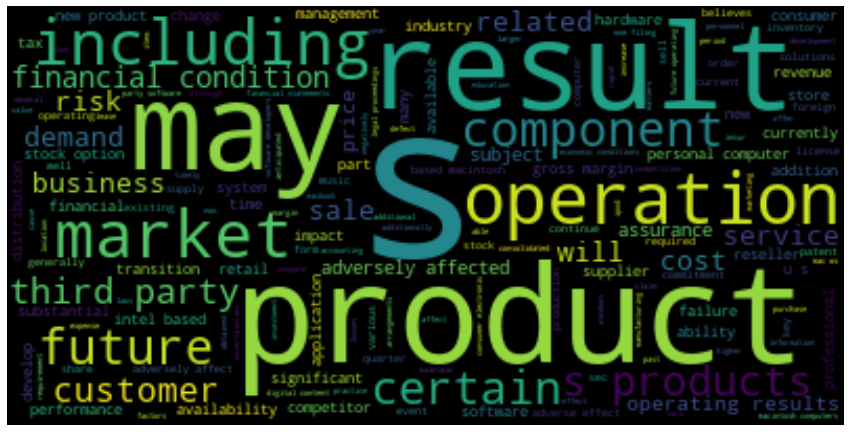

In [7]:
wordcloud = WordCloud(stopwords=STOPWORDS).generate(data.lower())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [6]:
doc = nlp(data)

In [7]:
sents = list(doc.sents)

In [8]:
# Render the dependency parse immediately inside Jupyter:
displacy.render(sents[15], style='ent', jupyter=True,
                options={'distance': 110})

In [9]:
list(sents[0].noun_chunks)

[the following factors,
 other factors,
 the Company’s operating results,
 financial condition,
 financial performance,
 a reliable indicator,
 future performance,
 investors,
 historical trends,
 results,
 trends,
 future periods]

In [10]:
# Perform sentiment analysis on the doc
res = get_sentiment(data)

In [11]:
print('Distribution: ')
print(res['prediction'].value_counts())

Distribution: 
neutral     151
negative     93
positive     29
Name: prediction, dtype: int64


In [17]:
print('Example of a sentence that has been classified as having negative sentiment:')
print(res.loc[res.prediction == 'negative', 'sentence'].iloc[1])
print()
print('Example of a sentence that has been classified as having neutral sentiment:')
print(res.loc[res.prediction == 'neutral', 'sentence'].iloc[10])
print()
print('Example of a sentence that has been classified as having neutral sentiment:')
print(res.loc[res.prediction == 'positive', 'sentence'].iloc[4])

Example of a sentence that has been classified as having negative sentiment:
On June 29, 2006, the Company announced that an internal review had discovered irregularities related to the issuance of certain stock option grants made between 1997 and 2001, including a grant to its Chief Executive Officer (“CEO”), Steve Jobs.

Example of a sentence that has been classified as having neutral sentiment:
With the filing of this Form 10-K, the Company believes that it has remedied its non-compliance with Marketplace Rule 4310(c)(14), subject to NASDAQ’s affirmative completion of its compliance protocols and its notification of the Company accordingly.

Example of a sentence that has been classified as having neutral sentiment:
Additionally, there has been a trend towards consolidation in the personal computer industry that has resulted in larger and potentially stronger competitors in the Company’s markets.


In [18]:
neg_sentences = ' '.join(
    res.loc[res.prediction == 'negative', 'sentence'].values)

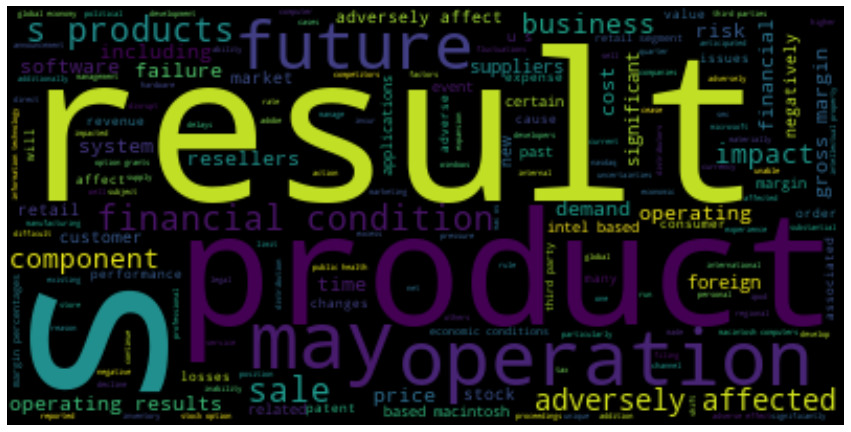

In [19]:
wordcloud = WordCloud(stopwords=STOPWORDS).generate(neg_sentences.lower())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [3]:
corpus = []
risk_file_names = glob.glob(os.path.join(Config.risk_dir(), '10k20f_5', '*.txt'))
for risk_file_name in tqdm(risk_file_names):
    with open(risk_file_name, 'r', encoding='utf-8') as risk_file:
        #import pdb; pdb.set_trace()
        docu = risk_file.read()
        if len(word_tokenize(docu)) > 100:
            corpus.append(docu)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3096/3096 [01:56<00:00, 26.50it/s]


In [4]:
print(f'Out of {len(risk_file_names)}, {len(corpus)} had valid text.')

Out of 3096, 1953 had valid text.


In [ ]:
model = Top2Vec(corpus, speed='deep-learn', workers=8)

2020-11-28 13:48:16,250 - top2vec - INFO - Pre-processing documents for training
2020-11-28 13:48:59,777 - top2vec - INFO - Creating joint document/word embedding


In [22]:
print(f'Number of topics: {model.get_num_topics()}')

Number of topics: 34


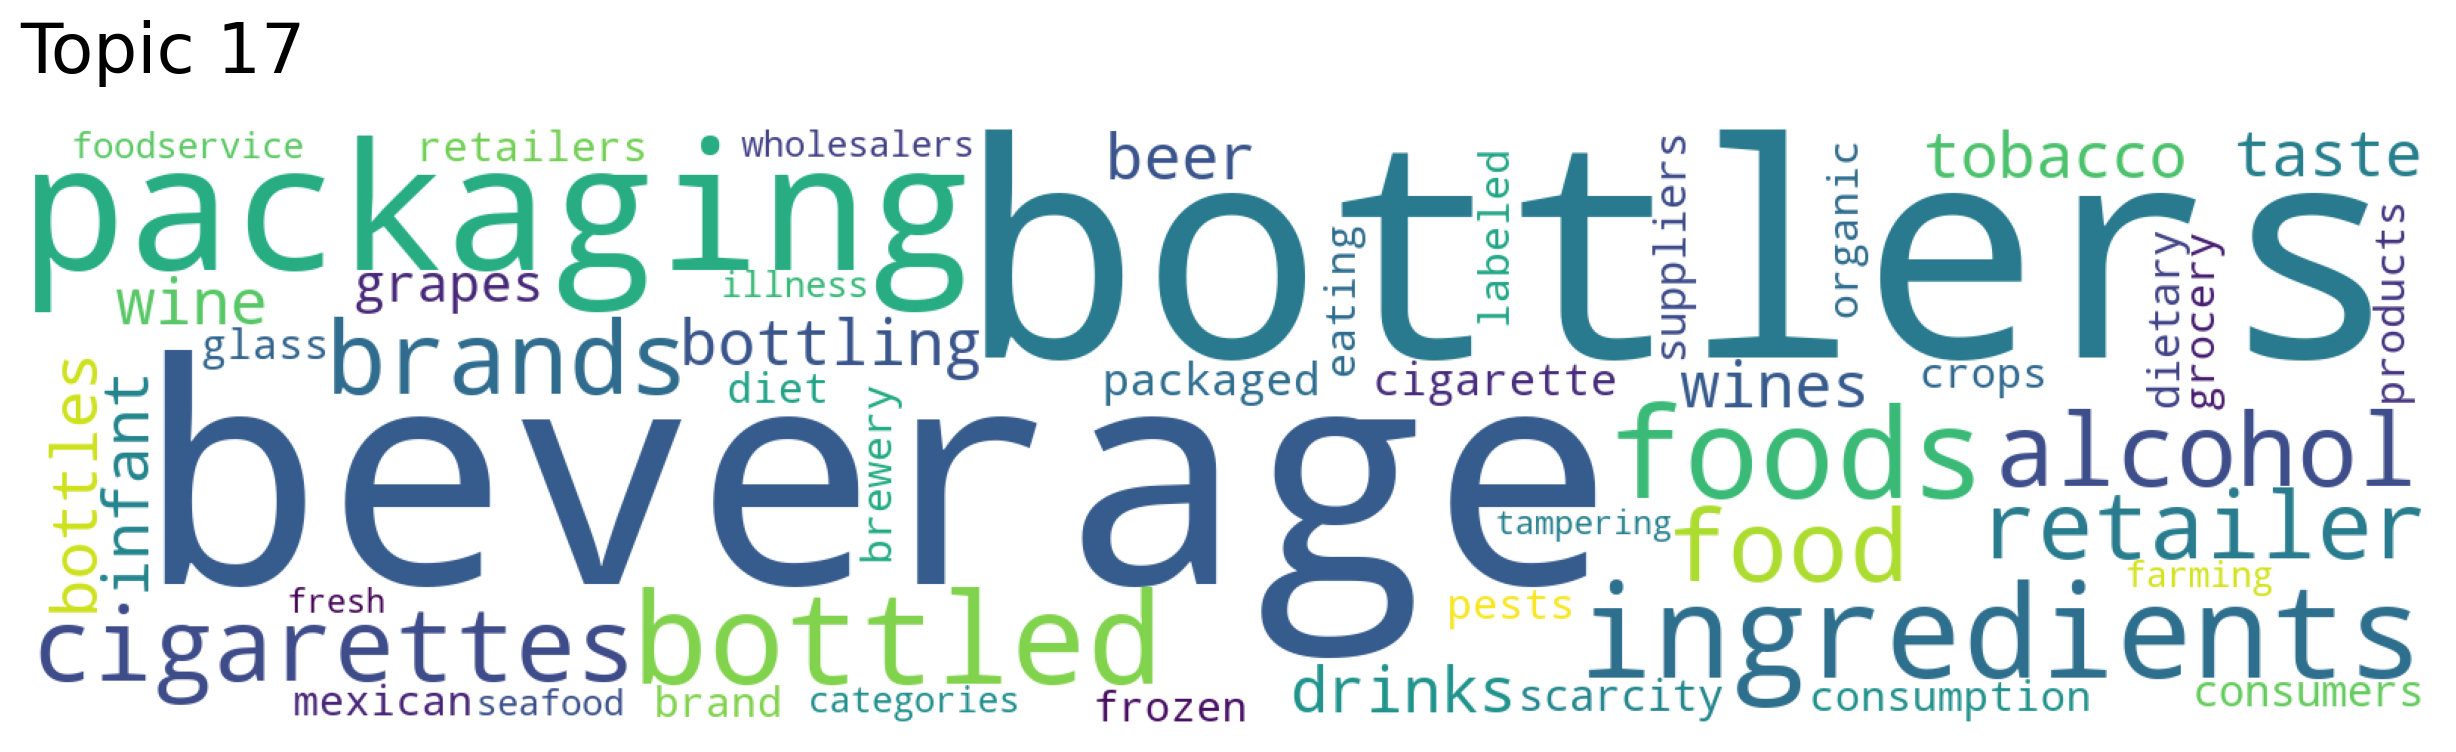

In [30]:
model.generate_topic_wordcloud(topic_num=17, background_color='white')

In [31]:
model.save('top2vec_model')

In [18]:
documents, document_scores, document_ids = model.search_documents_by_keywords(
    keywords=['bank'], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f'Document: {doc_id}, Score: {score}')
    print('-----------')
    print(doc[:20])
    print('-----------')
    print()

Document: 542, Score: 0.5796
-----------
Risk Factors46Item 1
-----------

Document: 153, Score: 0.5537
-----------
18Item 1B. Unresolve
-----------

Document: 674, Score: 0.4955
-----------
Our
business, and an
-----------

Document: 1109, Score: 0.4879
-----------
Risk Factors15Item 1
-----------

Document: 541, Score: 0.4861
-----------
Our business, and an
-----------



In [19]:
from bertopic import BERTopic

In [20]:
bert_model = BERTopic("distilbert-base-nli-mean-tokens", verbose=True)

In [21]:
topics, probabilities = bert_model.fit_transform(corpus)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245M/245M [01:06<00:00, 3.67MB/s]
2020-11-27 17:09:57,430 - BERTopic - Loaded BERT model
2020-11-27 17:28:32,800 - BERTopic - Transformed documents to Embeddings
2020-11-27 17:28:40,845 - BERTopic - Reduced dimensionality with UMAP
2020-11-27 17:28:41,151 - BERTopic - Clustered UMAP embeddings with HDBSCAN


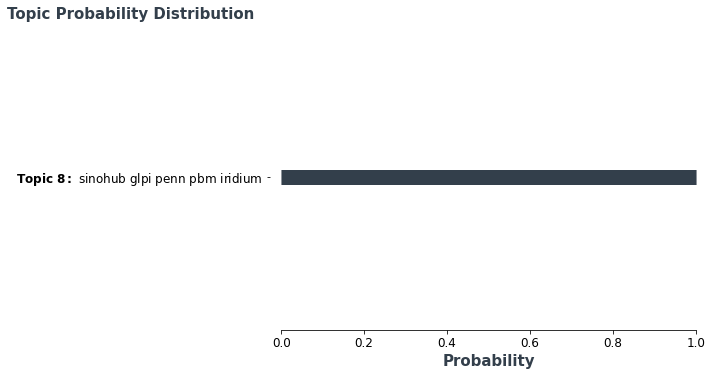

In [25]:
bert_model.visualize_distribution(probabilities[2])